In [63]:
import os
from icecream import ic # debugging output
import numpy as np
import pandas as pd
from pandas import DataFrame as DF  # create and typehint shorthand
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


sequence_length = 10 # X time series sequence length

# interpretation of raw data for human analysis
dataset_interpretation: dict = {
    'gender': {
        1: 'female',
        2: 'male'
    },
    'afftype': {
        1: 'bipolar II',
        2: 'unipolar depressive',
        3: 'bipolar I'
    },
    'melanch': {
        1: 'melancholia',
        2: 'no melancholia'
    },
    'inpatient': {
        1: 'inpatient',
        2: 'outpatient'
    },
    'marriage': {
        1: 'married or cohabiting',
        2: 'single'
    },
    'work': {
        1: 'working or studying',
        2: 'unemployed/sick leave/pension'
    }
}

# convert data to ML compatible data
dataset_interpretation_reversed: dict = {
    'age': {
        '20-24': 1.0,
        '25-29': 2.0,
        '30-34': 3.0,
        '35-39': 4.0,
        '40-44': 5.0,
        '45-49': 6.0,
        '50-54': 7.0,
        '55-59': 8.0,
        '60-64': 9.0,
        '65-69': 10.0,
    },
    'gender': {
        'female': 1.0,
        'male': 2.0,
    },
    'work': {
        'working or studying': 1.0,
        'unemployed/sick leave/pension': 2.0
    }
}

top_path = rf'{os.getcwd()}'  # raw strings allow consistent path slashes
ic(top_path)

data_path = top_path + r'/data' # if repo pulled fully

class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_losses = {'loss': [], 'val_loss': []}
        #ic(self.epoch_losses)
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_losses['loss'].append(logs.get('loss'))
        self.epoch_losses['val_loss'].append(logs.get('val_loss'))
        #ic(self.epoch_losses)


def interpret_values(row, conversions, float_conv=0) -> pd.Series:
    for category in conversions:
        if category in row:
            if category == 'age':
                row[category] = str(conversions[category].get(row[category], row[category]))
            elif float_conv == 1:
                row[category] = float(conversions[category].get(row[category], row[category]))
            else:
                row[category] = conversions[category].get(row[category], row[category])
    return row

condition_numbers: list = []

def load_condition_data(scores_data_interpreted) -> dict:
    numbers = scores_data_interpreted['number']
    global condition_numbers  # call and edit the global variable
    condition_numbers = [item for item in numbers if not item.startswith('control')]

    condition: dict = {}
    condition_path = data_path + r'/condition'

    for num in condition_numbers:
        condition_path_num = condition_path + rf'/{num}.csv'
        activity_data_temp = pd.read_csv(condition_path_num)
        new_activity_data_temp = DF()

        new_activity_data_temp['timestamp'] = pd.to_datetime(activity_data_temp['timestamp'])
        new_activity_data_temp['time_since_start[mins]'] = (new_activity_data_temp['timestamp'] - \
            new_activity_data_temp['timestamp'].iloc[0]).dt.total_seconds() / 60.0
        new_activity_data_temp['activity'] = activity_data_temp['activity']

        condition[num] = new_activity_data_temp

    # ic(condition)
    return condition # return explicitly despite global definition

def load_scores() -> DF:
    scores_path = data_path + r'/scores.csv'
    scores_data = pd.read_csv(scores_path)
    #ic(scores_data.head())  # check first few records in terminal output

    scores_data_interpreted = DF()
    for i, row in scores_data.iterrows():
        row_interpreted = interpret_values(row, dataset_interpretation)
        scores_data_interpreted = pd.concat([scores_data_interpreted, row_interpreted], axis=1)

    scores_data_interpreted = scores_data_interpreted.T  # transpose

    # ic(scores_data_interpreted.head())
    return scores_data_interpreted

def create_sequences(data, sequence_length) -> np.ndarray:
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

def scale_and_prepare(scores: DF = None, condition: dict = None):
    """
    Scales data and prepares data format for model training.
    :param scores: DF
    :param condition: dict
    :return: patient_scaled_data dict, demographic_encoded DF, X_time_series np.ndarray
    """
    # Scale the activity data
    global sequence_length
    scalers = {}
    patient_scaled_data = {}
    X_time_series = {}

    for patient_id, patient_df in condition.items():
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(np.array(patient_df['activity']).reshape(-1, 1))
        scalers[patient_id] = scaler
        patient_scaled_data[patient_id] = scaled_data

    for patient_id, scaled_data in patient_scaled_data.items():
        X_time_series[patient_id] = create_sequences(scaled_data, sequence_length)

    key_predictors = ['number', 'age', 'gender', 'madrs1', 'madrs2']

    demographic_temp: DF = scores[scores['number'].str.startswith('condition')]

    demographic = DF()
    for i, field in enumerate(key_predictors):
        demographic = pd.concat([demographic, demographic_temp[field]], axis=1)

    # filter out all rows and columns except number condition_n, age, gender, madrs1, madrs2
    demographic_encoded = DF()  # re-encode data back to integers
    for i, row in demographic.iterrows():
        row_interpreted = interpret_values(row, dataset_interpretation_reversed, float_conv=1)
        # print(f"{row=}, {row_interpreted=}")
        demographic_encoded = pd.concat([demographic_encoded, row_interpreted], axis=1)
    demographic_encoded = demographic_encoded.T

    #ic(demographic_encoded.head())

    return patient_scaled_data, demographic_encoded, X_time_series

def build_LSTM(time_series_shape, supplementary_shape) -> Model:
    # Define LSTM branch for time series data with dropout and L2 regularization
    time_series_input = Input(shape=time_series_shape, name='time_series_input')
    x1 = LSTM(64, kernel_regularizer=l2(0.01))(time_series_input)
    x1 = Dropout(0.5)(x1)

    # Define dense branch for supplementary data with dropout and L2 regularization
    supplementary_input = Input(shape=supplementary_shape, name='supplementary_input')
    x2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(supplementary_input)
    x2 = Dropout(0.5)(x2)

    # Merge branches
    merged = concatenate([x1, x2])
    output = Dense(1, activation='linear')(merged)

    # Define and compile model
    model = Model(inputs=[time_series_input, supplementary_input], outputs=output)
    model.compile(optimizer=Adam(), loss='mse')
    
    return model


def train_LSTM(scores: pd.DataFrame = None, condition: dict = None) -> Model:
    patient_scaled_activity_dict, demographic_refined, X_time_series = scale_and_prepare(scores=scores, condition=condition)

    X_time_series_combined = []
    X_supplementary_combined = []
    y_combined = []

    for patient_id, sequences in X_time_series.items():
        demographic_data = demographic_refined.loc[demographic_refined['number'] == patient_id].drop(columns=['number']).values
        if len(demographic_data) == 0:
            continue

        demographic_data_repeated = np.repeat(demographic_data, sequences.shape[0], axis=0)
        X_time_series_combined.append(sequences)
        X_supplementary_combined.append(demographic_data_repeated)

        y = demographic_refined.loc[demographic_refined['number'] == patient_id, 'madrs2'].values
        if len(y) > 0:
            y_combined.extend([y[0]] * sequences.shape[0])

    X_time_series_combined = np.concatenate(X_time_series_combined, axis=0).astype('float32')
    X_supplementary_combined = np.concatenate(X_supplementary_combined, axis=0).astype('float32')
    y_combined = np.array(y_combined, dtype=np.float32)

    model = build_LSTM(time_series_shape=(X_time_series_combined.shape[1], X_time_series_combined.shape[2]),
                             supplementary_shape=(X_supplementary_combined.shape[1],))

    # Split data into training and validation sets
    X_train_ts, X_val_ts, X_train_sup, X_val_sup, y_train, y_val = train_test_split(X_time_series_combined,
                                                                                    X_supplementary_combined,
                                                                                    y_combined,
                                                                                    test_size=0.3,
                                                                                    random_state=42)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        # likely will not activate unless epoch number increased from 10
    losses = LossHistory()
    # Train the model
    model_fitted = model.fit([X_train_ts, X_train_sup], y_train, epochs=30, batch_size=32,
                             validation_data=([X_val_ts, X_val_sup], y_val), callbacks=[early_stopping, losses])
    model.save('lstm_test.keras')
    ic(losses.epoch_losses)
    # Predict on validation data
    y_pred = model.predict([X_val_ts, X_val_sup])

    # Calculate accuracy metrics
    mse = mean_squared_error(y_val, y_pred)
    print(f'Mean Squared Error: {mse:.3e}')
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse:.3e}')

    mae = mean_absolute_error(y_val, y_pred)
    print(f'Mean Absolute Error: {mae:.3e}')

    r2 = r2_score(y_val, y_pred)
    print(f'R-squared: {r2:.3f}')

    return model, losses



ic| top_path: '/Users/williamhampshire/Desktop/pycharm/MLproject'


In [64]:
scores_df = load_scores()  # dataframe of scores
condition_dict_df = load_condition_data(scores_df)  # dict of key=condition_n, value=dataframe activity time series
    # cols = timestamp, time_since_start[mins], activity
models, losses = train_LSTM(scores=scores_df, condition=condition_dict_df)

Epoch 1/30



KeyboardInterrupt



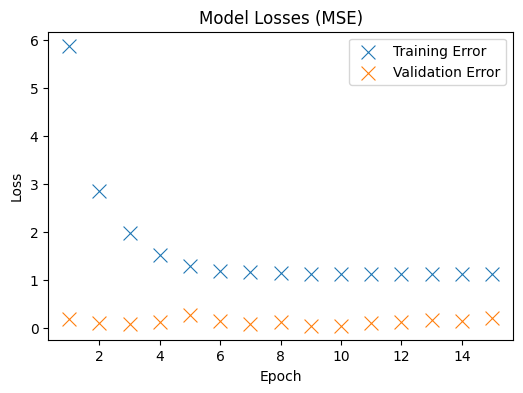

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

losses_df = DF(losses.epoch_losses)
plt.figure(figsize=(6, 4))
losses_df['epoch'] = losses_df.index + 1

sns.scatterplot(x='epoch', y='loss', data=losses_df, label='Training Error', marker='x', s=100)
sns.scatterplot(x='epoch', y='val_loss', data=losses_df, label='Validation Error', marker='x', s=100)

plt.title('Model Losses (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()


ic| len(colours): 10


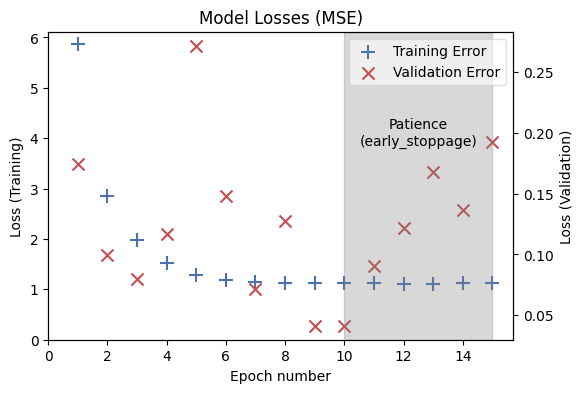

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame as DF  # Optional if not already imported

# .png (rasterised), .svg (vector graphic) output?
image_save_type = ['svg', 'png']  # 'png' or 'svg'

# get default deep colours
colours = sns.color_palette('deep')
ic(len(colours))

losses_df = DF(losses.epoch_losses)

# plot data
plt.figure(figsize=(6, 4))
losses_df['epoch'] = losses_df.index + 1  # Add an epoch column for the x-axis
ax1 = sns.scatterplot(x='epoch', y='loss', data=losses_df, label='Training Error', 
                      color=colours[0], marker='+', s=100, linewidth=1.5)
ax2 = ax1.twinx()
sns.scatterplot(x='epoch', y='val_loss', data=losses_df, label='Validation Error', 
                color=colours[3], marker='x', s=75, linewidth=1.5, 
                ax=ax2)
# patience
plt.axvspan(10, 15, color='gray', alpha=0.3)
plt.text(12.5, 0.2, 'Patience\n(early_stoppage)', horizontalalignment='center', verticalalignment='center', fontsize=10)

# create 1 single legend
ax1.legend_.remove()
ax2.legend_.remove()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
plt.legend(handles, labels, facecolor='white', loc='upper right' ,framealpha=0.6)

# title and labels
plt.title('Model Losses (MSE)')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Loss (Training)')
ax1.set_ylim(0)
ax2.set_ylabel('Loss (Validation)')
ax1.set_xlim(0)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # integers only on x scale 

# Save figure
if 'png' in image_save_type:
    plt.savefig("model_losses.png", dpi=150, transparent=False)
if 'svg' in image_save_type:
    plt.savefig("model_losses.svg", format='svg', bbox_inches='tight')

plt.show()
